# Make model data

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns

import requests
import datetime
import pickle

import eeweather
import pytz

import tensorflow as tf
print(tf.__version__)

2.2.0


## Hyperparameter

In [20]:
PATH_DF_01 = '/home/ubuntu/github/airflow-automation/02_df/df_model_data.pkl'

URL_EIA_01 = 'http://api.eia.gov/series/?api_key='
URL_EIA_02 = '&series_id='
API_KEY = '1f251657d4404b4115a5d852206cceb1'
SERIES_ID = 'EBA.PSCO-ALL.D.H'
NAME = 'load'

# denver international airport
LAT = 39.8328
LON = -104.6575

## Load data

In [4]:
url = URL_EIA_01 + API_KEY + URL_EIA_02 + SERIES_ID
print(url)

response = requests.get(url)
print('status_code', response.status_code)

data = response.json()['series'][0]['data']
df = pd.DataFrame(data, columns = ['period', 'value'])
df.index = pd.to_datetime(df['period'])
df = df.sort_index()

df_utc = df.copy()

df = df.tz_convert('America/Denver')
df = df.tz_localize(None)
df = df.loc[~df.index.duplicated(keep = 'first')]
df = df.rename(columns = {'value': NAME})
df = df.drop('period', axis = 1)
df = df.sort_index()

df_load = df.copy()

http://api.eia.gov/series/?api_key=1f251657d4404b4115a5d852206cceb1&series_id=EBA.PSCO-ALL.D.H
status_code 200


In [5]:
df_load.head(2)

,load
period,
2015-07-01 01:00:00,4875.0
2015-07-01 02:00:00,4618.0


In [6]:
df_load.tail(2)

,load
period,
2020-08-02 08:00:00,4642.0
2020-08-02 09:00:00,4918.0


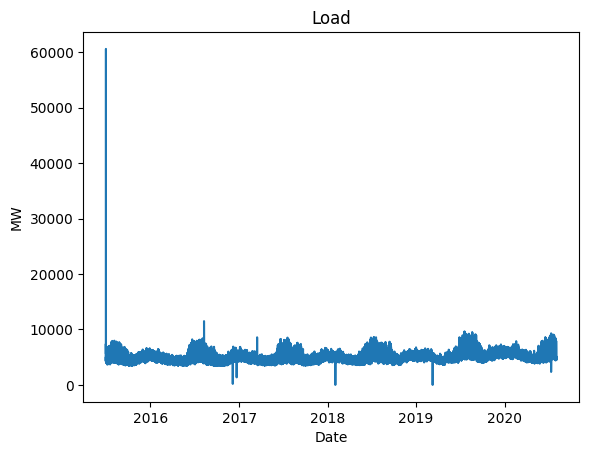

In [8]:
plt.plot(df_load['load'])
plt.title('Load')
plt.xlabel('Date')
plt.ylabel('MW')
plt.show()

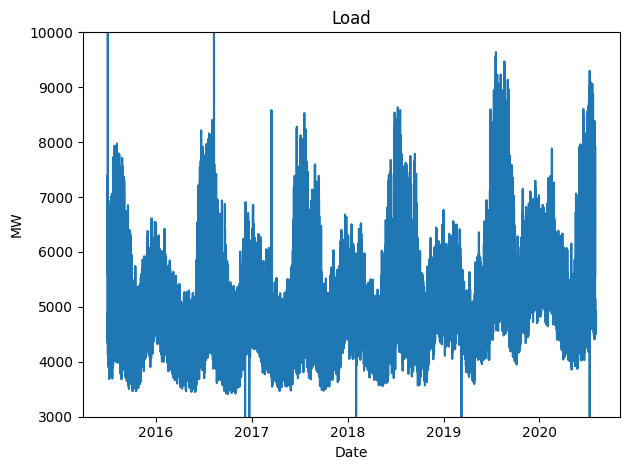

In [9]:
plt.plot(df_load['load'])
plt.ylim(3000, 10000)
plt.title('Load')
plt.xlabel('Date')
plt.ylabel('MW')
plt.tight_layout()
plt.show()

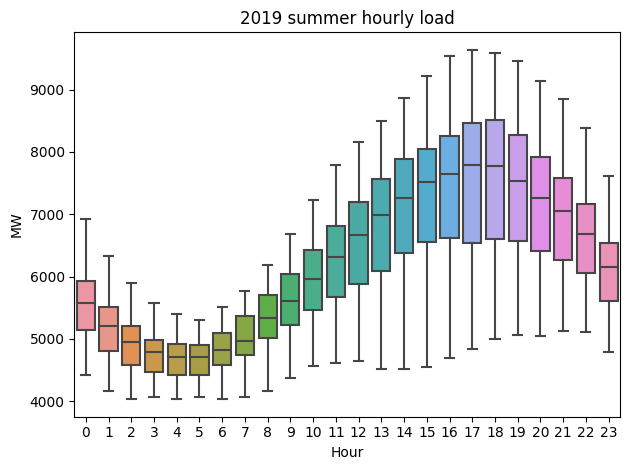

In [10]:
tmp = df_load.loc[(df_load.index.year == 2019) & 
                  (df_load.index.month.isin([6, 7, 8]))]

sns.boxplot(tmp.index.hour, tmp['load'])
plt.title('2019 summer hourly load')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.tight_layout()
plt.show()

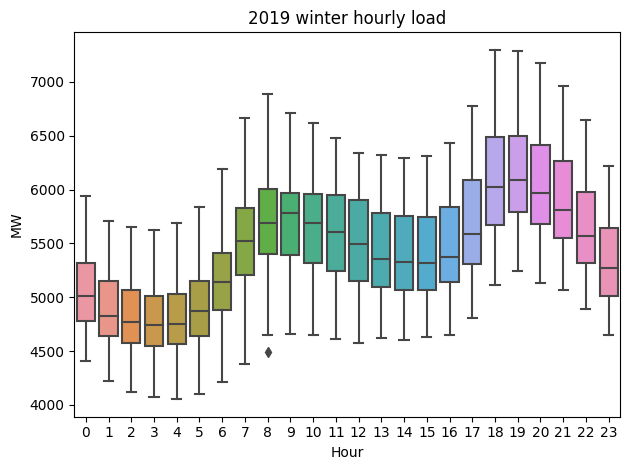

In [11]:
tmp = df_load.loc[(df_load.index.year == 2019) & 
                  (df_load.index.month.isin([12, 1, 2]))]

sns.boxplot(tmp.index.hour, tmp['load'])
plt.title('2019 winter hourly load')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.tight_layout()
plt.show()

## Temperature data

In [12]:
ranked_stations = eeweather.rank_stations(LAT, LON)
station, warnings = eeweather.select_station(ranked_stations)
print('station.name', station.name)
print('warnings', warnings)

start_date = datetime.datetime(df_utc.index[0].year, df_utc.index[0].month, df_utc.index[0].day, tzinfo = pytz.UTC)
end_date = datetime.datetime(df_utc.index[-1].year, df_utc.index[-1].month, df_utc.index[-1].day, tzinfo = pytz.UTC)
print(start_date, end_date)
tempC = station.load_isd_hourly_temp_data(start_date, end_date)
tempF = (tempC[0] * 1.8 + 32).to_frame(name = 'temp_f')

tempF = tempF.tz_convert('America/Denver')
tempF = tempF.tz_localize(None)
tempF = tempF.loc[~tempF.index.duplicated(keep = 'first')]

tempF = tempF.dropna()

df_temp = tempF.copy()

station.name DENVER INTERNATIONAL AIRPORT
warnings []
2015-07-01 00:00:00+00:00 2020-08-02 00:00:00+00:00


In [13]:
df_temp.head(2)

,temp_f
2015-06-30 18:00:00,82.23764
2015-06-30 19:00:00,81.21632


In [14]:
df_temp.tail(2)

,temp_f
2020-07-31 13:00:00,84.5801
2020-07-31 14:00:00,86.6285


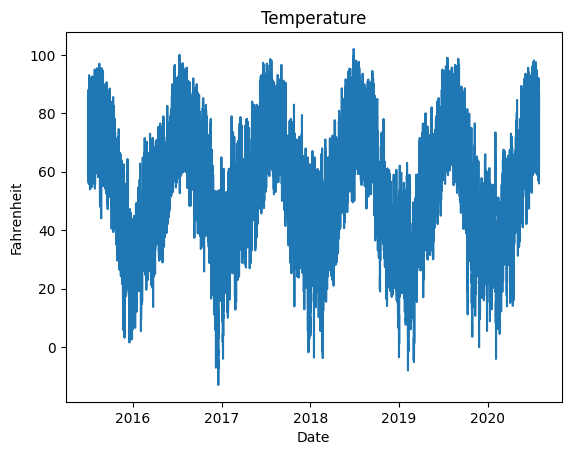

In [16]:
plt.plot(df_temp['temp_f'])
plt.title('Temperature')
plt.xlabel('Date')
plt.ylabel('Fahrenheit')
plt.show()

## Make model data

In [17]:
df_model = df_load.copy()
df_model['temp_f'] = df_temp['temp_f']
df_model['year'] = df_model.index.year
df_model['month'] = df_model.index.month
df_model['day'] = df_model.index.day
df_model['hour'] = df_model.index.hour
df_model['dow'] = df_model.index.dayofweek

In [18]:
df_model.head(2)

,load,temp_f,year,month,day,hour,dow
period,,,,,,,
2015-07-01 01:00:00,4875.0,68.77544,2015,7,1,1,2
2015-07-01 02:00:00,4618.0,66.80714,2015,7,1,2,2


In [19]:
df_model.tail(2)

,load,temp_f,year,month,day,hour,dow
period,,,,,,,
2020-08-02 08:00:00,4642.0,NaN,2020,8,2,8,6
2020-08-02 09:00:00,4918.0,NaN,2020,8,2,9,6


## Save dataframe

In [21]:
pickle.dump(df_model, open(PATH_DF_01, 'wb'))